This notebook aims to compare the original NO2 VCD product with derived LNOx VCD product.

In [1]:
from glob import glob
import xarray as xr
import proplot as pplt
import numpy as np
import matplotlib
import pandas as pd
from netCDF4 import Dataset
from wrf import getvar, latlon_coords, interplevel

import sys
sys.path.append('../scripts/')
from xin_cartopy import load_province

# Disable warnings
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
def get_uv(ds_wrf):
    # Extract the pressure, geopotential height, and wind variables
    p = getvar(ds_wrf, "pressure")
    # ua = getvar(ds_wrf, "ua", units="m s-1")
    # va = getvar(ds_wrf, "va", units="m s-1")

    # interpolate u/v winds to the layer of Upper Troposphere
    ut_pressure = 400
    u_ut = interplevel(getvar(ds_wrf, "ua", units="m s-1"), p, ut_pressure)
    v_ut = interplevel(getvar(ds_wrf, "va", units="m s-1"), p, ut_pressure)


    # Get the lat/lon coordinates
    lats_wrf, lons_wrf = latlon_coords(p)

    return lons_wrf, lats_wrf, u_ut, v_ut

In [3]:
ds_wrf_1h = Dataset('../data/wrfchem/wrfout/20200901/wrfout_d04_2020-09-01_03_20_00_subset')
ds_wrf = Dataset('../data/wrfchem/wrfout/20200901/wrfout_d04_2020-09-01_05_20_00_subset')

lons_wrf, lats_wrf, u_ut, v_ut = get_uv(ds_wrf)
_, _, u_ut_1h, v_ut_1h = get_uv(ds_wrf_1h)

In [4]:
filelist_lnox = glob('../data/s5p_chem/lnox_500/S5P_CHEM_L2__NO2____20200901*nc')
filelist_nolnox = glob('../data/s5p_chem/nolnox/S5P_CHEM_L2__NO2____20200901*nc')

ds_s5p_2019 = xr.open_mfdataset(glob('../data/s5p_chem/lnox_500/S5P_CHEM_L2__NO2____20190725T*.nc'), group='S5P').isel(time=0)
ds_s5p = xr.open_mfdataset(filelist_lnox, group='S5P').isel(time=0)
ds_lnox = xr.open_mfdataset(filelist_lnox, group='CHEM')
ds_nolnox = xr.open_mfdataset(filelist_nolnox, group='CHEM')

In [5]:
df_ltng = pd.read_csv('../data/lightning/LtgFlashPortions20200901.csv')

pass_time = pd.to_datetime('2020-09-01 05:46')
delta = pd.to_datetime(df_ltng['timestamp']) - pass_time

df_ltng['delta'] = delta.dt.total_seconds()/60

# subset the lightning into two groups
delta_aged = (-180 < df_ltng['delta'])& (df_ltng['delta'] < -60)
delta_fresh = (-60 < df_ltng['delta'])& (df_ltng['delta'] < 0)

df_ltng_aged = df_ltng[delta_aged]
df_ltng_fresh = df_ltng[delta_fresh]

In [6]:
ds_lnox

<xarray.Dataset>
Dimensions:              (y: 500, x: 450, plevel: 36)
Dimensions without coordinates: y, x, plevel
Data variables: (12/16)
    amfTrop              (y, x) float32 dask.array<chunksize=(500, 450), meta=np.ndarray>
    amfTropVis           (y, x) float32 dask.array<chunksize=(500, 450), meta=np.ndarray>
    swClr                (plevel, y, x) float32 dask.array<chunksize=(36, 500, 450), meta=np.ndarray>
    swCld                (plevel, y, x) float32 dask.array<chunksize=(36, 500, 450), meta=np.ndarray>
    avgKernel            (y, x, plevel) float32 dask.array<chunksize=(500, 450, 36), meta=np.ndarray>
    no2apriori           (plevel, y, x) float32 dask.array<chunksize=(36, 500, 450), meta=np.ndarray>
    ...                   ...
    vcdGnd               (y, x) float32 dask.array<chunksize=(500, 450), meta=np.ndarray>
    tropopause_pressure  (y, x) float32 dask.array<chunksize=(500, 450), meta=np.ndarray>
    plevels              (plevel, y, x) float32 dask.array<chunksize=(36, 500, 450), meta=np.ndarray>
    o3apriori            (plevel, y, x) float32 dask.array<chunksize=(36, 500, 450), meta=np.ndarray>
    noapriori            (plevel, y, x) float32 dask.array<chunksize=(36, 500, 450), meta=np.ndarray>
    vcdGnd_no            (y, x) float32 dask.array<chunksize=(500, 450), meta=np.ndarray>
Attributes:
    units:        unitless
    description:  Tropospheric air mass factor for total tropospheric NO2 cal...

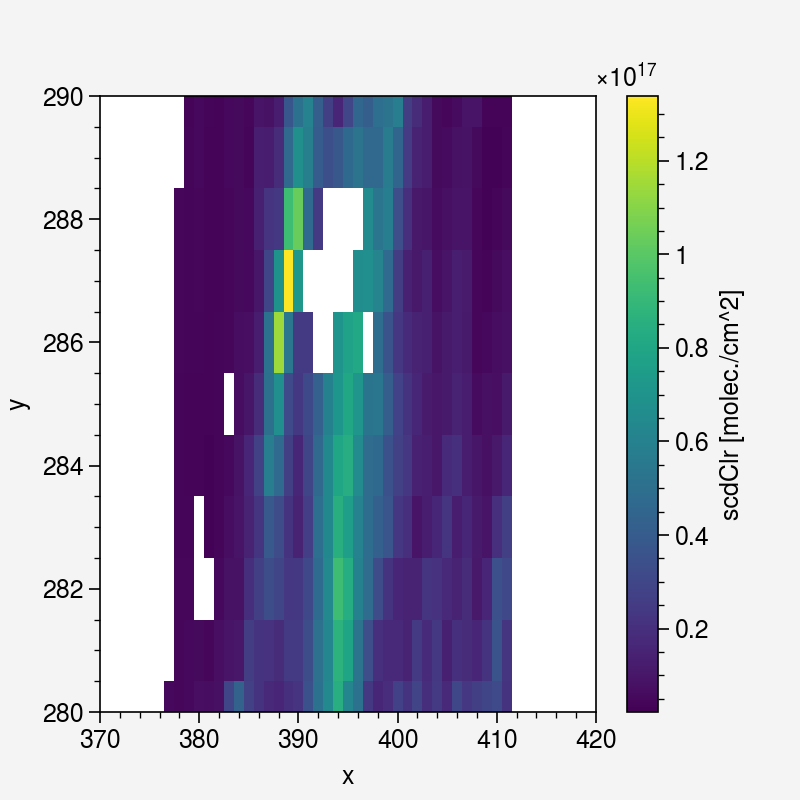

In [7]:
ds_lnox['scdClr'].where(ds_lnox['scdClr']!=0).plot(xlim=(370, 420), ylim=(280, 290))

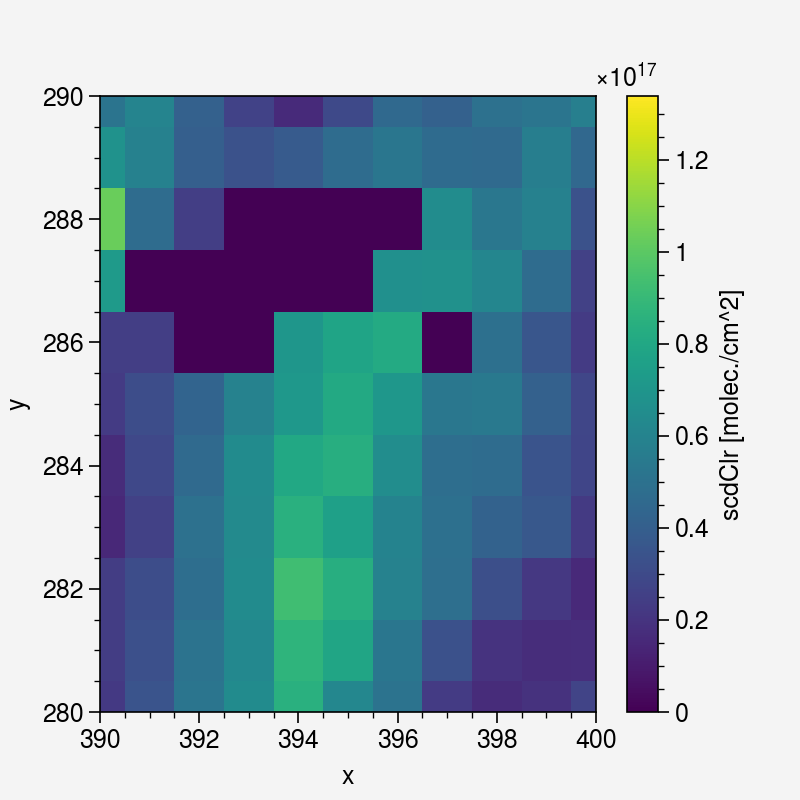

In [8]:
ds_lnox['scdClr'].plot(xlim=(390, 400), ylim=(280, 290))

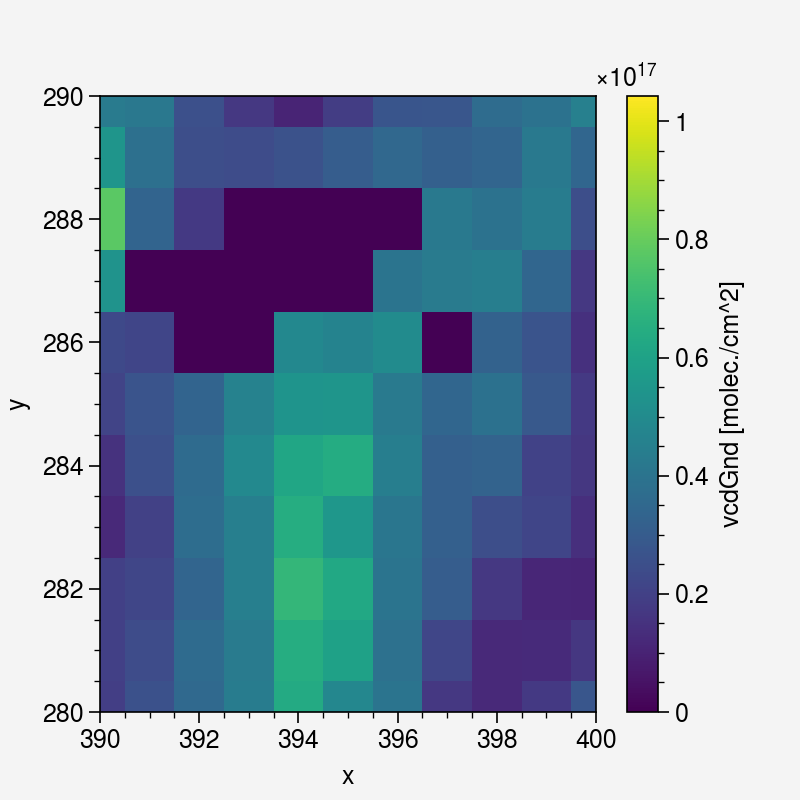

In [9]:
ds_lnox['vcdGnd'].plot(xlim=(390, 400), ylim=(280, 290))

In [10]:
ds_lnox['vcdGnd'].sel(x=392, y=287).values

array(0., dtype=float32)

In [11]:
scdTrop = ds_s5p['nitrogendioxide_slant_column_density'] - ds_s5p['nitrogendioxide_stratospheric_column'] * ds_s5p['air_mass_factor_stratosphere']

amfTrop = ds_lnox['amfTrop']
vcdGnd_lnox = ds_lnox['vcdGnd']
vcdLno2 = ds_lnox['vcdGnd'] - ds_nolnox['vcdGnd']
vcdLno = ds_lnox['vcdGnd_no'] - ds_nolnox['vcdGnd_no']

amf_lnox = amfTrop * vcdGnd_lnox / (vcdLno2 + vcdLno)
amf_lno2 = amfTrop * vcdGnd_lnox / (vcdLno2)

lnoxTrop = scdTrop/amf_lnox
lno2Trop = scdTrop/amf_lno2

In [12]:
def plot_scd_flag(ds_s5p, axs):
    '''Plot VCD and scd_flag'''
    lons = ds_s5p['assembled_lon_bounds']
    lats = ds_s5p['assembled_lat_bounds']

    # --- flag ---
    ax = axs[0]
    m = ax.pcolormesh(lons, lats,
                    ds_s5p['no2_scd_flag'],
                    cmap='Paired',
                    values=np.arange(-1, 6))
    ax.colorbar([m], loc='r', label='', ticks=1)


    # --- orginal NO2 VCD ---
    ax = axs[1]
    m = ax.pcolormesh(lons, lats,
                      ds_s5p['nitrogendioxide_tropospheric_column']*6.02214e19/1e16,
                      cmap='viridis', vmin=0, vmax=2, extend='both', discrete=False)
    ax.colorbar([m], loc='r', label='(10$^{16}$ molec. / cm$^2$)')

    # --- filtered NO2 VCD ---
    ax = axs[2]
    m = ax.pcolormesh(lons, lats,
                      ds_s5p['nitrogendioxide_tropospheric_column'].where(ds_s5p['no2_scd_flag']==0)*6.02214e19/1e16,
                      cmap='viridis', vmin=0, vmax=2, extend='both', discrete=False)
    ax.colorbar([m], loc='r', label='(10$^{16}$ molec. / cm$^2$)')

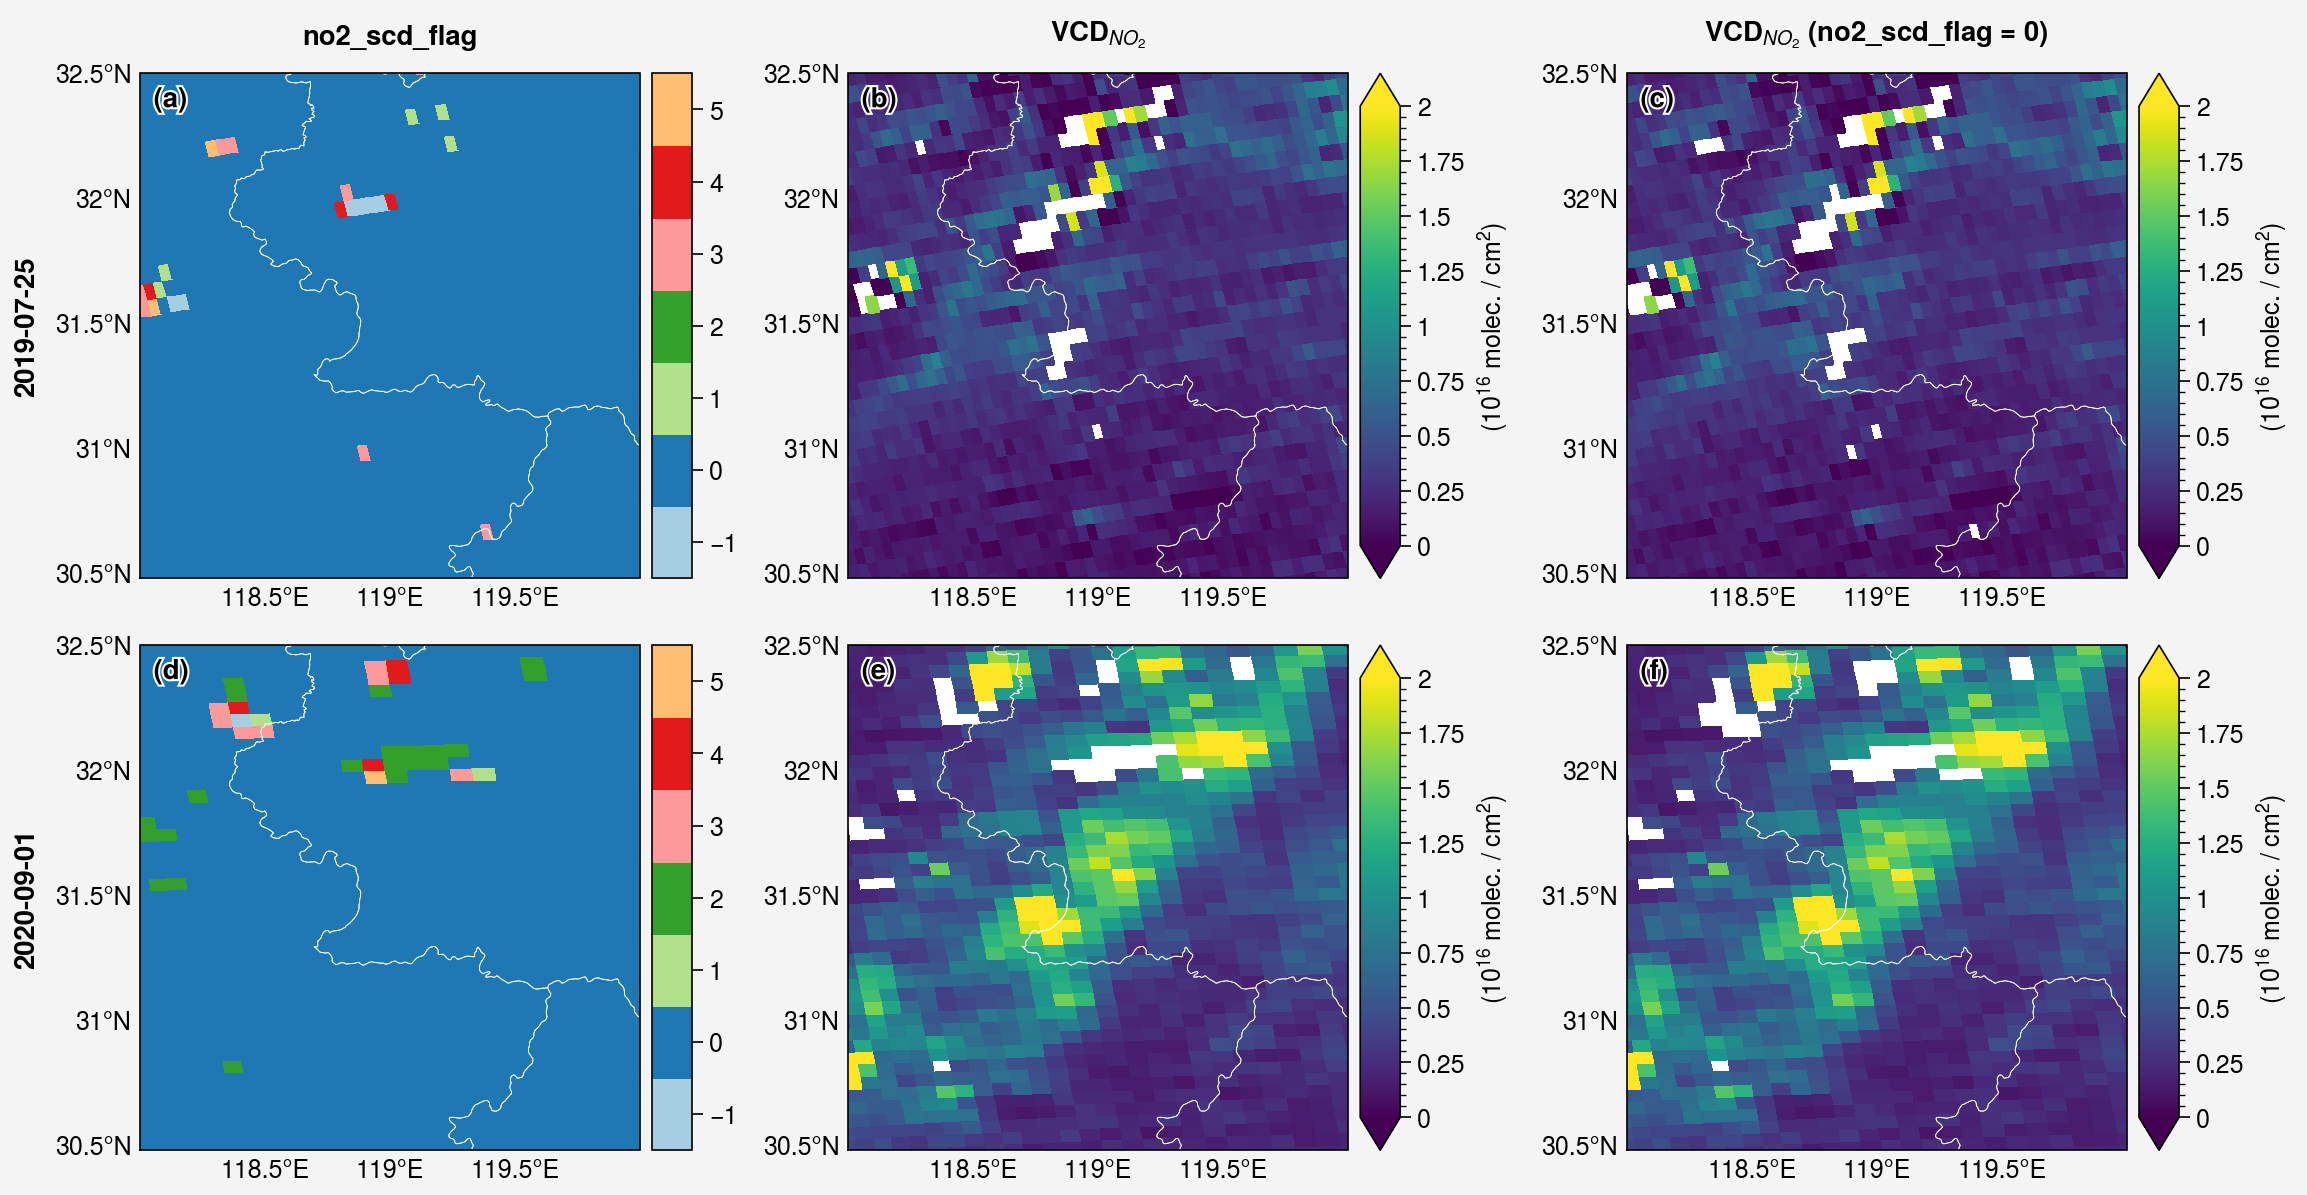

In [13]:
fig, axs = pplt.subplots(proj='pcarree', nrows=2, ncols=3)

provinces = load_province()
axs.add_feature(provinces, edgecolor='w', linewidth=.3)

# extend = [117.49, 120.5, 30, 33]
extend = [118, 120, 30.49, 32.51]
lon_d = 0.5; lat_d = 0.5

plot_scd_flag(ds_s5p_2019, axs[:3])
plot_scd_flag(ds_s5p, axs[3:])

# format axes
axs.format(abc=True, abcstyle='(a)', abcloc='ul',
           lonlines=lon_d,
           latlines=lat_d,
           lonlim=(extend[0], extend[1]),
           latlim=(extend[2], extend[3]),
           leftlabels=['2019-07-25', '2020-09-01'],
           toplabels=['no2_scd_flag', 'VCD$_{NO_2}$', 'VCD$_{NO_2}$ (no2_scd_flag = 0)'],
           dms=False,
           lonlabels=True,
           latlabels=True,
           grid=False)

fig.savefig('../figures/no2_scd_flag.png')

In [14]:
def plot_region(ax):
    # add larger rectangle for flashes
    # rec_ll_flash = (118.1, 30.5)
    # rec_width_flash = 1.6
    # rec_height_flash = 1.55

    # ax.add_patch(matplotlib.patches.Rectangle(rec_ll_flash,
    #                                     rec_width_flash,
    #                                     rec_height_flash,
    #                                     fill=None,
    #                                     edgecolor='white',
    #                                     linestyle='-'))

    # add larger rectangle for VCDs
    # rec_ll_vcd = (118.1, 30.51)
    # rec_width_vcd = 1.59
    # rec_height_vcd = 1.45
    rec_ll_vcd = (118.25, 30.51)
    rec_width_vcd = 1.4
    rec_height_vcd = 1.45

    ax.add_patch(matplotlib.patches.Rectangle(rec_ll_vcd,
                                        rec_width_vcd,
                                        rec_height_vcd,
                                        fill=None,
                                        edgecolor='white',
                                        linestyle='--'))

def plot_lightning(ax, df, vmin, vmax, cmap):
    '''Plot the lightning dots colored by relative time'''
    s = ax.scatter(df['longitude'], df['latitude'],
                   marker="$\u25EF$", c=df['delta'],
                   cmap=cmap, vmin=vmin, vmax=vmax,
                   cmap_kw={'left':0.2},
                   s=5)
    ax.colorbar(s, loc='b', label='Flash Time (mins)')

def plot_wind(ax, lon, lat, u, v, color='w', qk=True):
    step = 10
    Q = ax.quiver(lon[::step,::step], lat[::step,::step],
                  u[::step, ::step], v[::step, ::step],
                  pivot='middle',
                  c=color,
                  )
    if qk:
        ax.quiverkey(Q, 0.05, -0.15,                  # x,y label position
                    10, str(10)+' m s$^{-1}$ (2 hours before TROPOMI overpass)', # choose units + update string
                    labelpos='E',                # add label to the right
                    color='gray8', coordinates='axes',
                    )

        ax.quiverkey(Q, 0.05, -0.25,                  # x,y label position
                    10, str(10)+' m s$^{-1}$ (TROPOMI overpass)', # choose units + update string
                    labelpos='E',                # add label to the right
                    color='orange8', coordinates='axes',
                    )


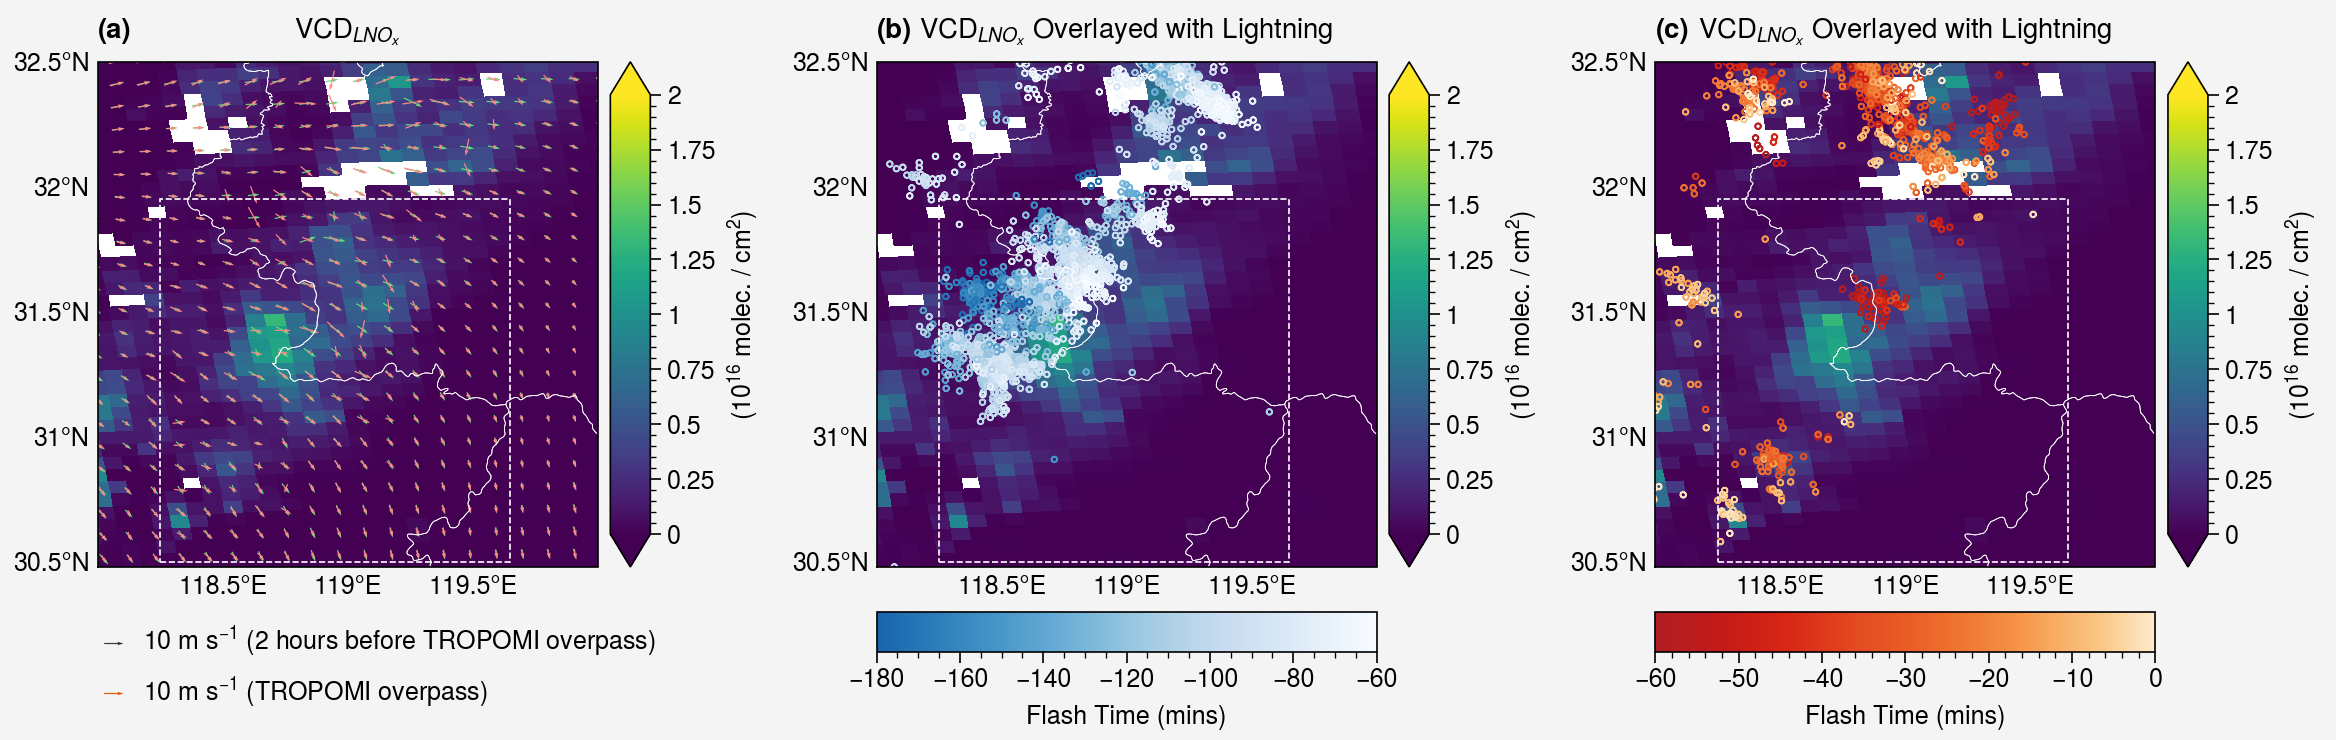

In [15]:
fig, axs = pplt.subplots(proj='pcarree', nrows=1, ncols=3)

# extend = [117.49, 120.5, 30, 33]
extend = [118, 120, 30.49, 32.51]

lons = ds_s5p['assembled_lon_bounds']
lats = ds_s5p['assembled_lat_bounds']


# --- LNOx VCD ---
# plot LNOx as background of three subplots
m = axs.pcolormesh(lons, lats,
                lnoxTrop.where(ds_s5p['no2_scd_flag']==0)*6.02214e19/1e16,
                cmap='viridis', vmin=0, vmax=2, extend='both', discrete=False)

# fig.colorbar([m], rows=(1,2), loc='r', label='(10$^{16}$ molec. / cm$^2$)')
axs.colorbar([m[0]], loc='r', label='(10$^{16}$ molec. / cm$^2$)')


ax = axs[0]
# UT wind
plot_wind(ax, lons_wrf, lats_wrf, u_ut_1h, v_ut_1h, color='green4')
plot_wind(ax, lons_wrf, lats_wrf, u_ut, v_ut, color='red4', qk=False)

ax.format(title='VCD$_{LNO_x}$')

# --- Aged Lightning ---
ax = axs[1]
plot_lightning(ax, df_ltng_aged, vmin=-180, vmax=-60, cmap='Blues_r')#'Algae_r')

ax.format(title='VCD$_{LNO_x}$ Overlayed with Lightning')

# --- Lightning and pixels
ax = axs[2]
plot_lightning(ax, df_ltng_fresh, vmin=-60, vmax=0, cmap='Reds2_r')
ax.format(title='VCD$_{LNO_x}$ Overlayed with Lightning')

# add region rectangle
plot_region(axs[0])
plot_region(axs[1])
plot_region(axs[2])

# format axes
axs.format(abc=True, abcstyle='(a)', abcloc='l',
           lonlines=lon_d,
           latlines=lat_d,
           lonlim=(extend[0], extend[1]),
           latlim=(extend[2], extend[3]),
           dms=False,
           lonlabels=True,
           latlabels=True,
           grid=False)

provinces = load_province()
axs.add_feature(provinces, edgecolor='w', linewidth=.3)
fig.savefig('../figures/vcd_lnox.png')

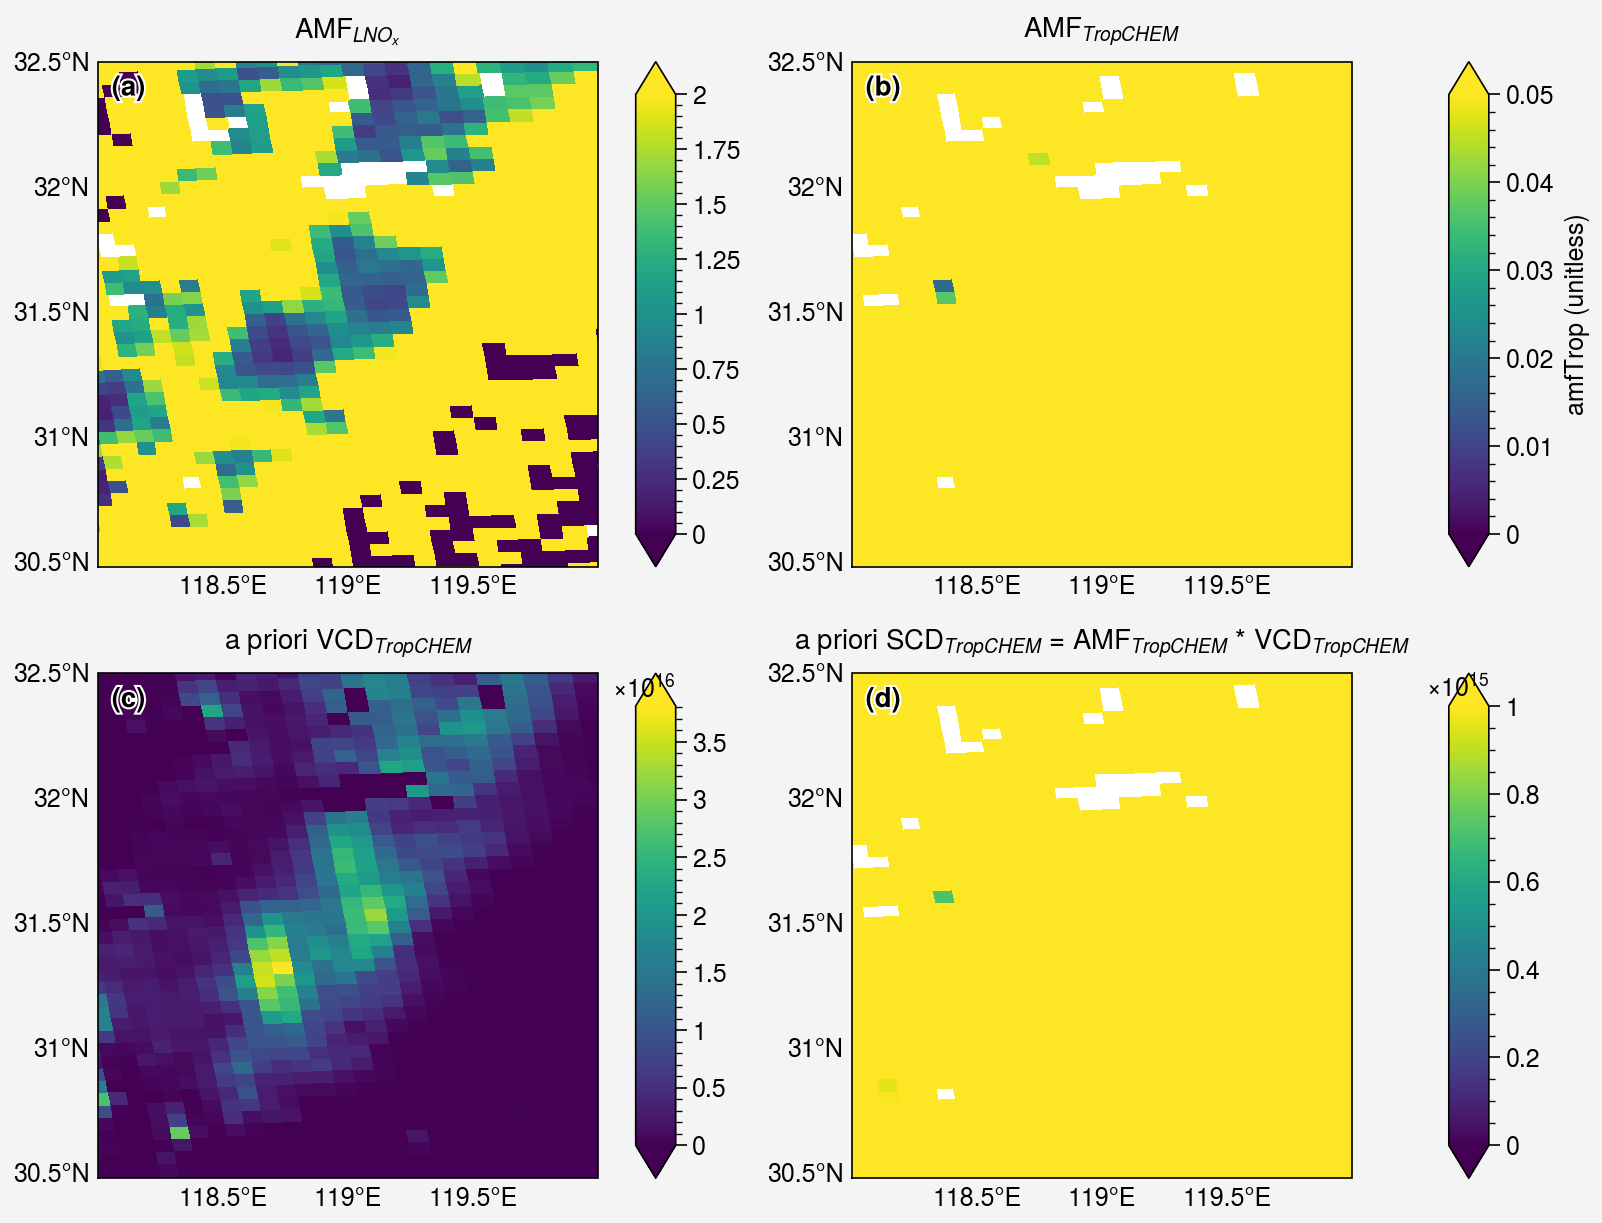

In [16]:
fig, axs = pplt.subplots(proj='pcarree', nrows=2, ncols=2)

# extend = [117.49, 120.5, 30, 33]
extend = [118, 120, 30.49, 32.51]

lons = ds_s5p['assembled_lon_bounds']
lats = ds_s5p['assembled_lat_bounds']

# --- NO2 VCD ---
ax = axs[0]
m = ax.pcolormesh(lons, lats,
                  amf_lnox,
                  cmap='viridis', vmin=0, vmax=2, extend='both', discrete=False)
ax.colorbar([m], loc='r')#, label='(10$^{16}$ molec. / cm$^2$)')
ax.format(title='AMF$_{LNO_x}$')

# AMF Trop
ax = axs[1]
m = ax.pcolormesh(lons, lats,
                  amfTrop,
                  cmap='viridis', vmin=0, vmax=5e-2, extend='both', discrete=False)
ax.colorbar([m], loc='r')#, label='(10$^{16}$ molec. / cm$^2$)')
ax.format(title='AMF$_{TropCHEM}$')



# --- NO2 VCD ---
ax = axs[2]
m = ax.pcolormesh(lons, lats,
                #   vcdGnd_lnox*6.02214e19/1e16,
                # vcdGnd_lnox,
                  (vcdLno2 + vcdLno),#*6.02214e19/1e16,
                  cmap='viridis', vmin=0, vmax=None, extend='both', discrete=False)
ax.colorbar([m], loc='r')#, label='(10$^{16}$ molec. / cm$^2$)')
ax.format(title='a priori VCD$_{TropCHEM}$')

# --- NO2 VCD ---
ax = axs[3]
m = ax.pcolormesh(lons, lats,
                  (amfTrop * vcdGnd_lnox),#*6.02214e19/1e16,
                  cmap='viridis', vmin=0, vmax=1e15, extend='both', discrete=False)
ax.colorbar([m], loc='r')#, label='(10$^{16}$ molec. / cm$^2$)')
ax.format(title='a priori SCD$_{TropCHEM}}$ = AMF$_{TropCHEM}$ * VCD$_{TropCHEM}$')


# format axes
axs.format(abc=True, abcstyle='(a)', abcloc='ul',
           lonlines=lon_d,
           latlines=lat_d,
           lonlim=(extend[0], extend[1]),
           latlim=(extend[2], extend[3]),
           dms=False,
           lonlabels=True,
           latlabels=True,
           grid=False)

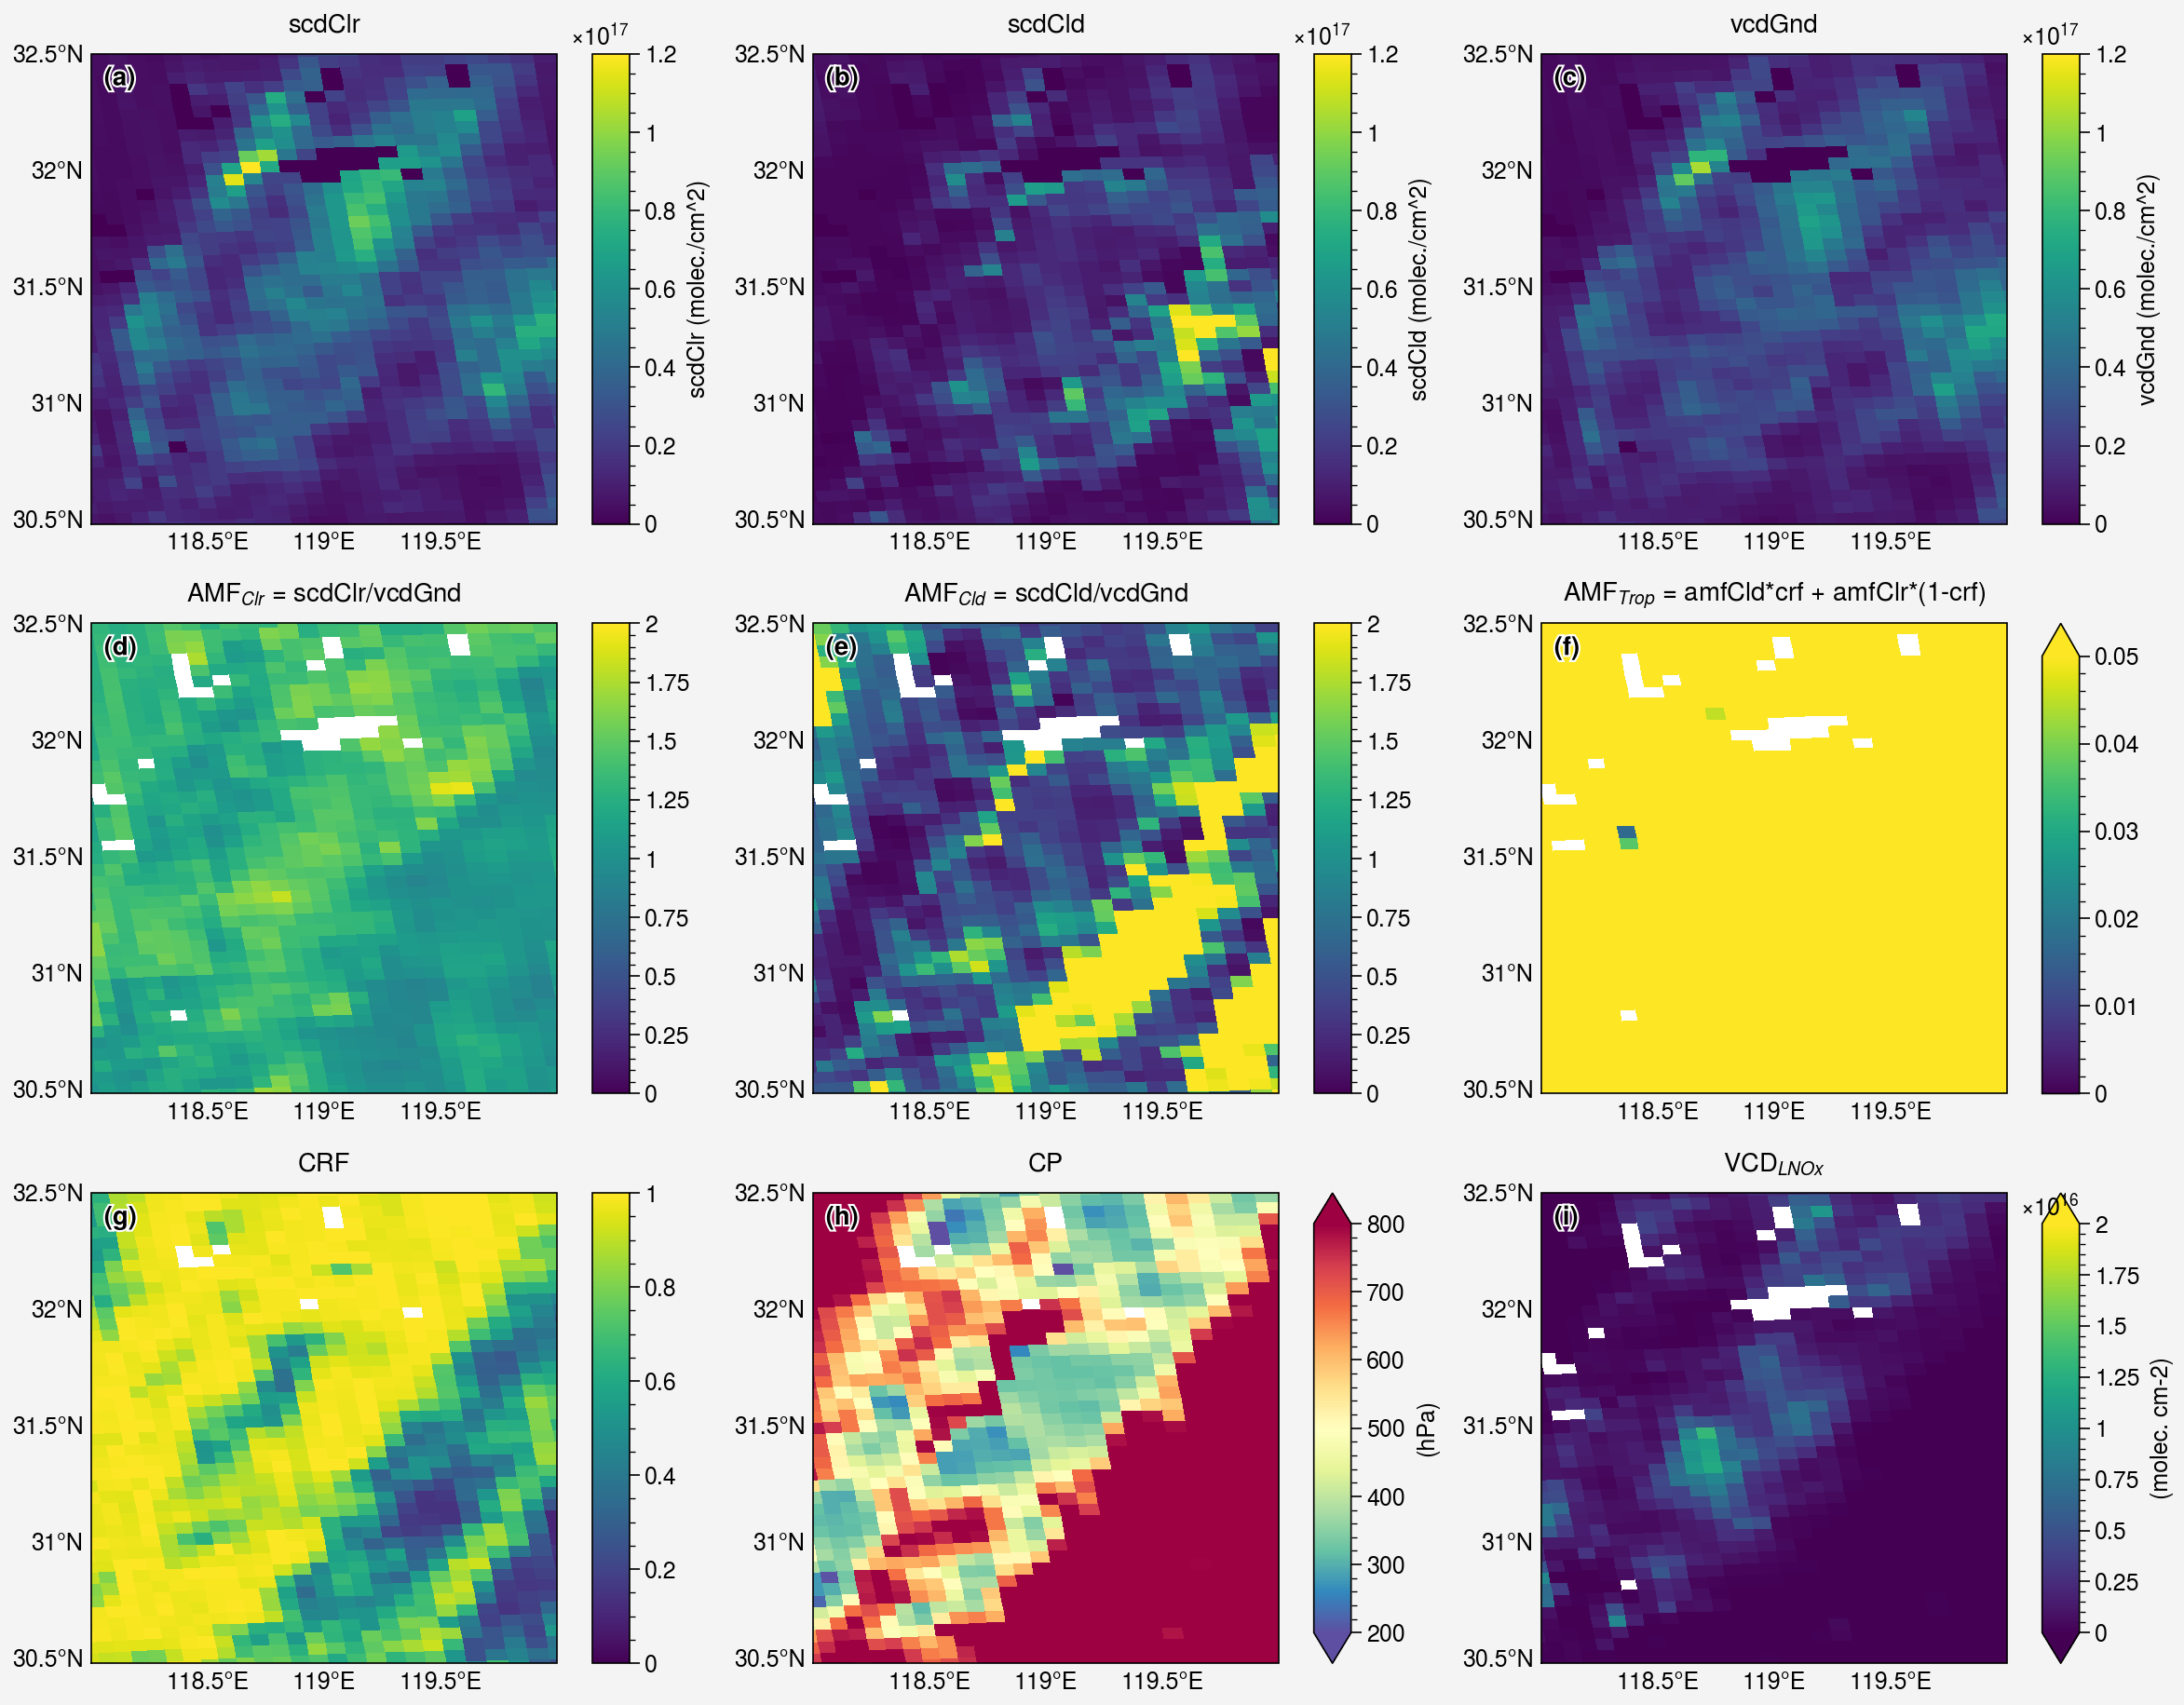

In [17]:
fig, axs = pplt.subplots(proj='pcarree', nrows=3, ncols=3)

# extend = [117.49, 120.5, 30, 33]
extend = [118, 120, 30.49, 32.51]

lons = ds_s5p['assembled_lon_bounds']
lats = ds_s5p['assembled_lat_bounds']

ax = axs[0]
m = ax.pcolormesh(lons, lats,
                  ds_lnox['scdClr'],
                  cmap='viridis', vmin=0, vmax=1.2e17, discrete=False)
ax.colorbar([m], loc='r')
ax.format(title='scdClr')

ax = axs[1]
m = ax.pcolormesh(lons, lats,
                  ds_lnox['scdCld'],
                  cmap='viridis', vmin=0, vmax=1.2e17,discrete=False)
ax.colorbar([m], loc='r')
ax.format(title='scdCld')

ax = axs[2]
m = ax.pcolormesh(lons, lats,
                  ds_lnox['vcdGnd'],
                  cmap='viridis', vmin=0, vmax=1.2e17,discrete=False)
ax.colorbar([m], loc='r')
ax.format(title='vcdGnd')

ax = axs[3]
m = ax.pcolormesh(lons, lats,
                  ds_lnox['scdClr']/ds_lnox['vcdGnd'],
                  cmap='viridis', vmin=0, vmax=2, discrete=False)
ax.colorbar([m], loc='r')
ax.format(title='AMF$_{Clr}$ = scdClr/vcdGnd')

ax = axs[4]
m = ax.pcolormesh(lons, lats,
                  ds_lnox['scdCld']/ds_lnox['vcdGnd'],
                  cmap='viridis', vmin=0, vmax=2, discrete=False)
ax.colorbar([m], loc='r')
ax.format(title='AMF$_{Cld}$ = scdCld/vcdGnd')

ax = axs[5]
m = ax.pcolormesh(lons, lats,
                  ds_lnox['scdClr']/ds_lnox['vcdGnd']*(1-ds_s5p['cloud_radiance_fraction_nitrogendioxide_window'])\
                        +ds_lnox['scdCld']/ds_lnox['vcdGnd']*(ds_s5p['cloud_radiance_fraction_nitrogendioxide_window']),
                  cmap='viridis', vmin=0, vmax=0.05, discrete=False, extend='max')
ax.colorbar([m], loc='r')
ax.format(title='AMF$_{Trop}$ = amfCld*crf + amfClr*(1-crf)')


ax = axs[6]
m = ax.pcolormesh(lons, lats,
                  ds_s5p['cloud_radiance_fraction_nitrogendioxide_window'],
                  cmap='viridis', vmin=0, vmax=1, discrete=False)
ax.colorbar([m], loc='r', label='')
ax.format(title='CRF')

ax = axs[7]
m = ax.pcolormesh(lons, lats,
                  ds_s5p['cloud_pressure_crb']/1e2,
                  cmap='Spectral_r', vmin=200, vmax=800, discrete=False, extend='both')
ax.colorbar([m], loc='r', label='(hPa)')
ax.format(title='CP')


ax = axs[8]
m = ax.pcolormesh(lons, lats,
                  lnoxTrop*6.02214e19,
                  cmap='viridis', vmin=0, vmax=2e16, discrete=False, extend='both')
ax.colorbar([m], loc='r', label='(molec. cm-2)')
ax.format(title='VCD$_{LNOx}$')

# format axes
axs.format(abc=True, abcstyle='(a)', abcloc='ul',
           lonlines=lon_d,
           latlines=lat_d,
           lonlim=(extend[0], extend[1]),
           latlim=(extend[2], extend[3]),
           dms=False,
           lonlabels=True,
           latlabels=True,
           grid=False)

In [18]:
ds_lnox['scdCld'].min().values

array(0., dtype=float32)

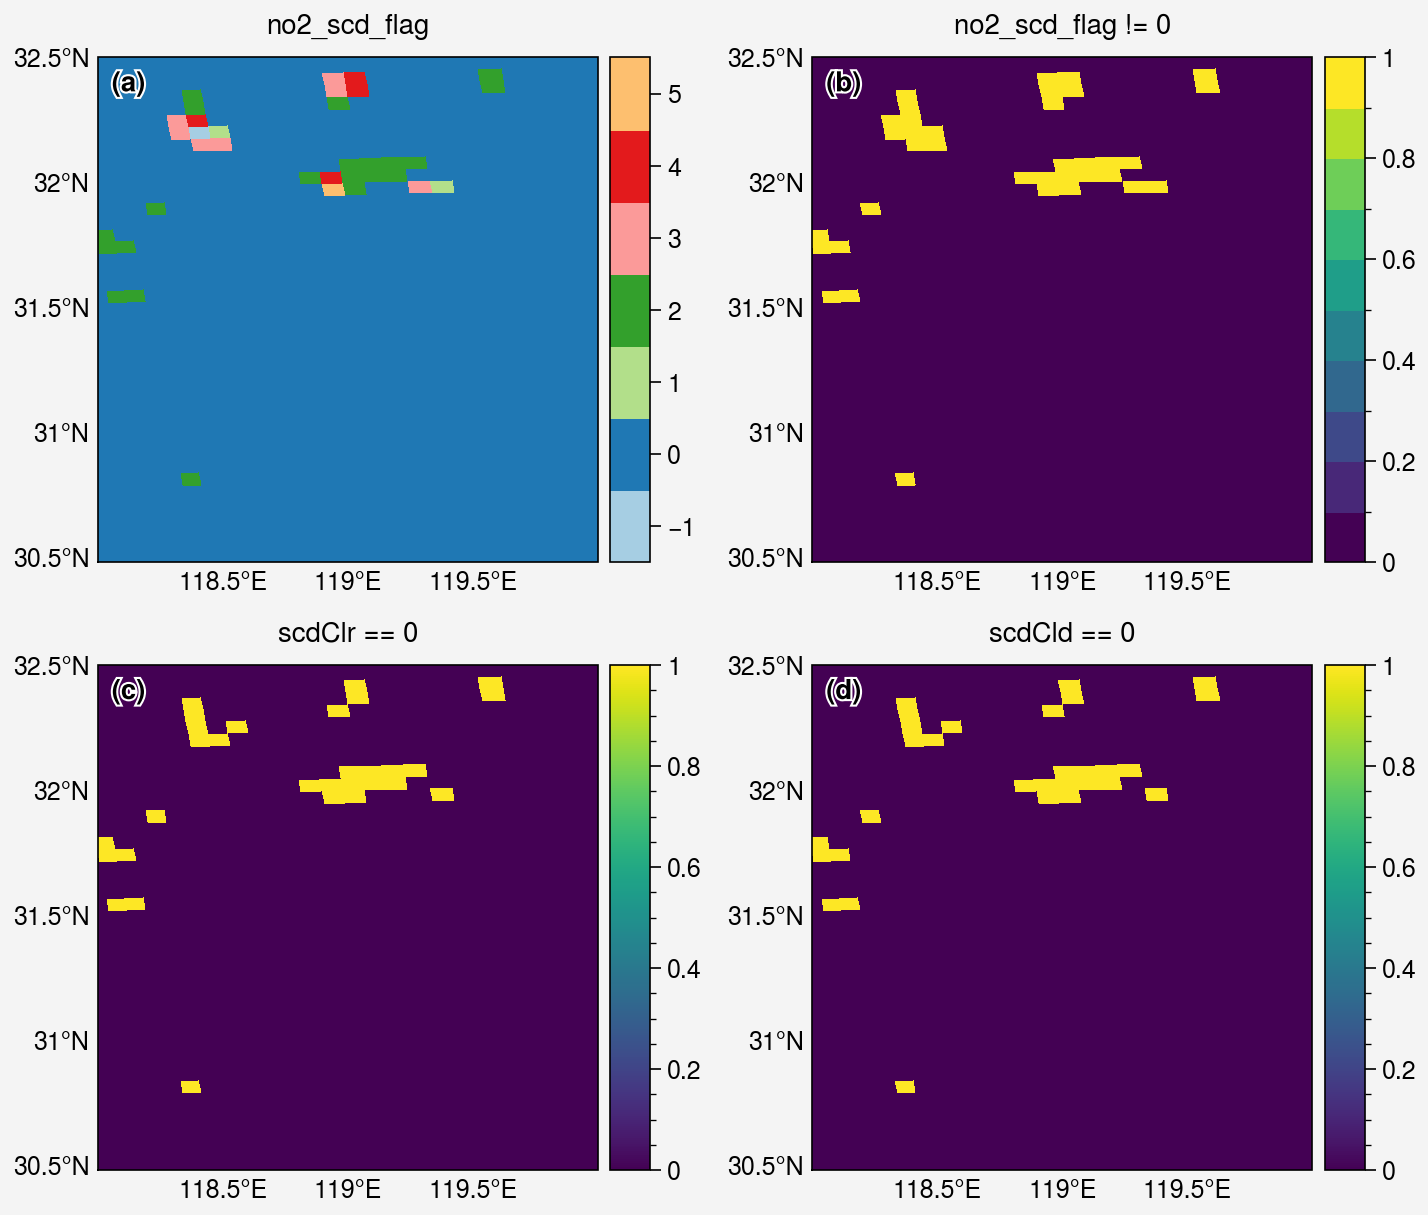

In [19]:
fig, axs = pplt.subplots(proj='pcarree', nrows=2, ncols=2)


ax = axs[0]
m = ax.pcolormesh(lons, lats,
                ds_s5p['no2_scd_flag'],
                cmap='Paired',
                values=np.arange(-1, 6))
ax.colorbar([m], loc='r', label='', ticks=1)
ax.format(title='no2_scd_flag')

ax = axs[1]
m = ax.pcolormesh(lons, lats,
                ds_s5p['no2_scd_flag']!=0,
                cmap='viridis')
ax.colorbar([m], loc='r', label='')#, ticks=1)
ax.format(title='no2_scd_flag != 0')


ax = axs[2]
m = ax.pcolormesh(lons, lats,
                  ds_lnox['scdClr']==0,
                  cmap='viridis', vmin=0, vmax=1,discrete=False)
ax.colorbar([m], loc='r', label='')
ax.format(title='scdClr == 0')

ax = axs[3]
m = ax.pcolormesh(lons, lats,
                  ds_lnox['scdCld']==0,
                  cmap='viridis', vmin=0, vmax=1,discrete=False)
ax.colorbar([m], loc='r', label='')
ax.format(title='scdCld == 0')

# format axes
axs.format(abc=True, abcstyle='(a)', abcloc='ul',
           lonlines=lon_d,
           latlines=lat_d,
           lonlim=(extend[0], extend[1]),
           latlim=(extend[2], extend[3]),
           dms=False,
           lonlabels=True,
           latlabels=True,
           grid=False)

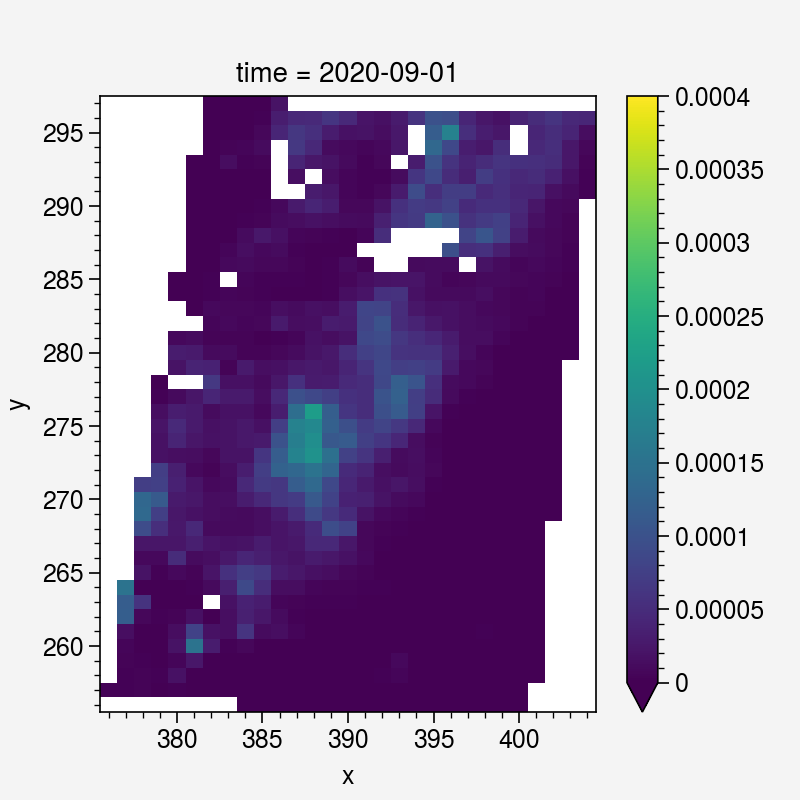

In [20]:
lnoxTrop.assign_coords({'x': range(lnoxTrop.sizes['x']), 'y': range(lnoxTrop.sizes['y'])}).where((ds_s5p['longitude']>extend[0]) 
                       &(ds_s5p['longitude']<extend[1])
                       &(ds_s5p['latitude']>extend[2])
                       &(ds_s5p['latitude']<extend[3])
                       ,drop=True).plot(vmin=0, vmax=4e-4)

In [21]:
sel_x = 388
sel_y = 266

lnoxTrop.sel(x=sel_x, y=sel_y).values, ds_lnox['scdCld'].sel(x=sel_x, y=sel_y).values

(array(2.8228565e-05, dtype=float32), array(1.887718e+16, dtype=float32))

In [22]:
ds_lnox['swCld'].sel(x=sel_x, y=sel_y).values

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.        , 0.12256319, 0.12182783,
       0.36274144, 2.9443622 , 2.9232    , 2.921481  , 2.9310408 ,
       2.9446068 , 2.9618185 , 2.981335  , 2.9992318 , 3.0152185 ,
       3.0275183 , 3.0392962 , 3.044597  , 3.0375793 , 3.013477  ,
       2.936291  , 2.8587706 , 2.7513182 , 2.7165647 , 2.632801  ,
       2.572948  , 2.569085  , 2.5721896 , 2.5752566 , 2.5664105 ,
       2.5391178 ], dtype=float32)

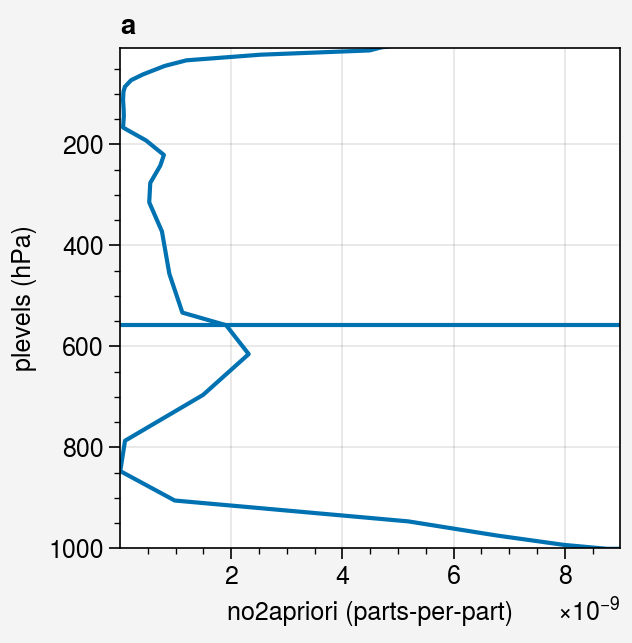

In [23]:
fig, axs = pplt.subplots()
axs.plot(ds_lnox['no2apriori'].sel(x=sel_x, y=sel_y),
         ds_lnox['plevels'].sel(x=sel_x, y=sel_y),
         )
axs.axhline(ds_s5p['cloud_pressure_crb'].sel(x=sel_x, y=sel_y)/1e2)
axs.format(ylim=(1000, 10))

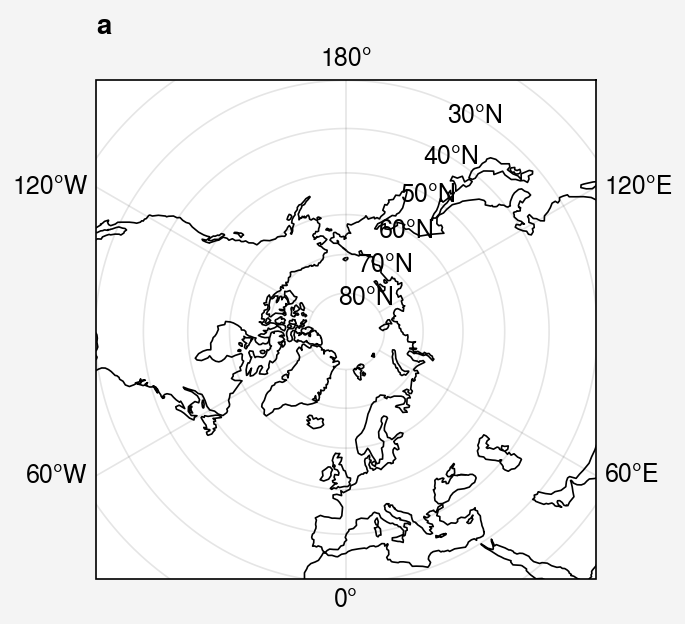

In [24]:
import proplot as pplt
fig, ax = pplt.subplot(
   proj='npstere', round=False, boundinglat=30, lonlabels='lrbt', latinline=True, coast=True
)